# 🚢 **Titanic Survival Prediction**

In [671]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

plt.style.use('bmh')
set_matplotlib_formats('retina')
sns.set_context('notebook')
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [672]:
home_dir = 'titanic/'
train_df = pd.read_csv(home_dir + 'train.csv')
test_df = pd.read_csv(home_dir + 'test.csv')
train_df.head(0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [673]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- **object cols**: Name, Sex, Ticket, Cabin, Embarked
- **numeric cols**: PassengerId, Pclass, Age, SibSp, Parch, Fare

## Handel Missing Values

In [674]:
# the zip function unpacks 2 pandas
# series 1 of the test_df nulls and the other of the train_df nulls into ordered tuples
def nulls_df(train_df, test_df):
    return pd.DataFrame(
        columns=['Train Nulls', 'Test Nulls'], 
        data=zip(train_df.drop('Survived', axis=1).isna().sum(axis=0), test_df.isna().sum(axis=0)),
        index=test_df.columns
    )
nulls_df(train_df, test_df)

,Train Nulls,Test Nulls
PassengerId,0,0
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327


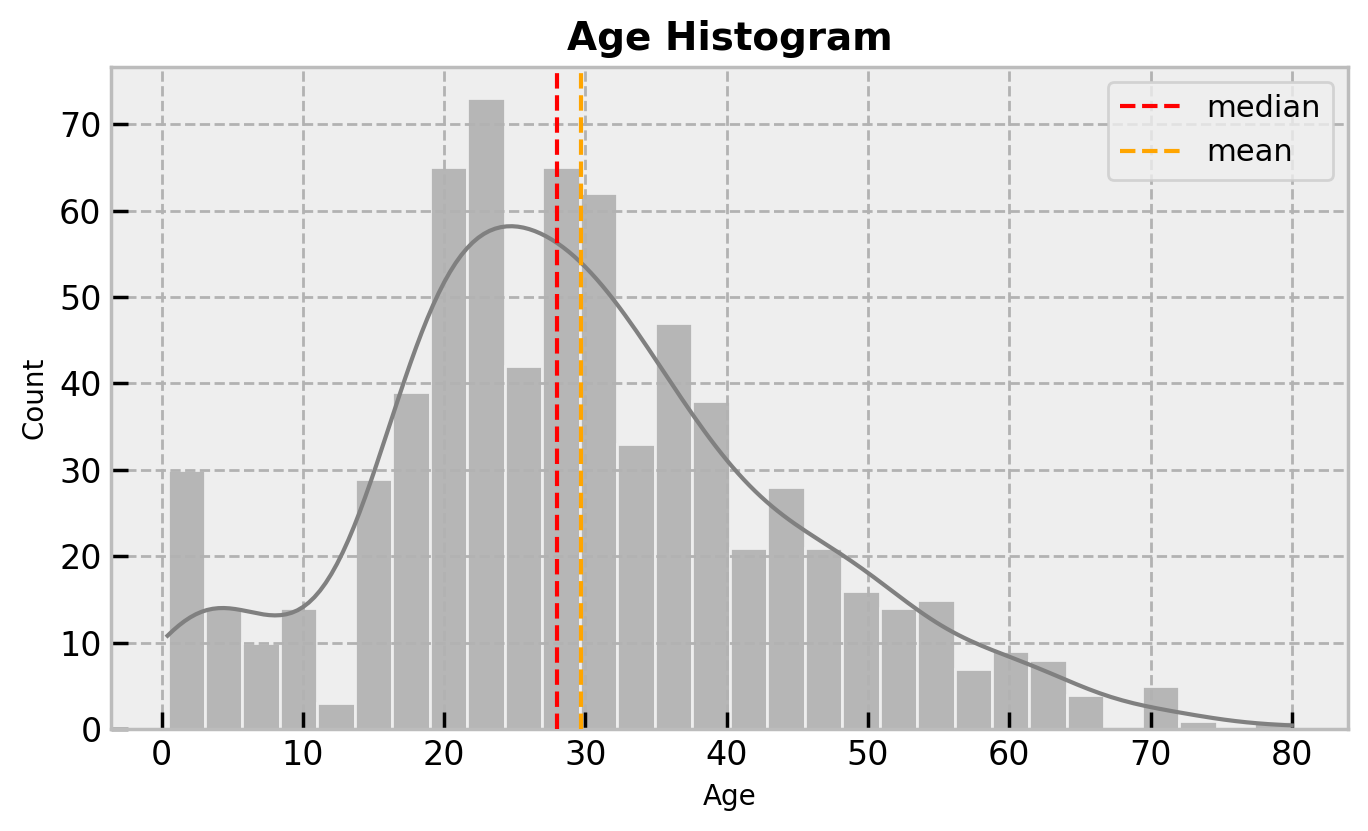

In [675]:
fig = plt.figure(figsize=(7, 4.3))

sns.histplot(data=train_df['Age'], kde=True, zorder=1, bins=30, color='grey')
plt.axvline(x=train_df.Age.median(), color='red', linestyle='--', label='median', zorder=3)
plt.axvline(x=train_df.Age.mean(), color='orange', linestyle='--', label='mean', zorder=3)

plt.title('Age Histogram', fontsize=14, weight='bold')
plt.xlabel('Age', fontsize=10), plt.ylabel('Count', fontsize=10)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [676]:
# fill missing ages with the median age
train_df['Age'].fillna(train_df.Age.median(), inplace=True)
test_df['Age'].fillna(train_df.Age.median(), inplace=True)
nulls_df(train_df, test_df).loc['Age'] == 0

Train Nulls    True
Test Nulls     True
Name: Age, dtype: bool

In [677]:
train_df[train_df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


both females survived and have missing embark values so they probably did not embark

In [678]:
train_df.drop(train_df[train_df.Embarked.isna()].index, axis=0, inplace=True)

In [679]:
nulls_df(train_df, test_df).loc['Embarked'] == 0

Train Nulls    True
Test Nulls     True
Name: Embarked, dtype: bool

In [680]:
test_df.Fare.fillna(0, axis=0, inplace=True)
nulls_df(train_df, test_df).loc['Fare'] == 0

Train Nulls    True
Test Nulls     True
Name: Fare, dtype: bool

In [681]:
nulls_df(train_df, test_df).loc['Cabin']

Train Nulls    687
Test Nulls     327
Name: Cabin, dtype: int64

In [682]:
print(f'There {train_df.Cabin.str[0].nunique()} Decks on the Titanic {sorted(train_df.Cabin.str[0].value_counts().index)}')
print(f'There {train_df.Cabin.str[1:].nunique()} Unique Cabins in this Dataset')

There 8 Decks on the Titanic ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
There 101 Unique Cabins in this Dataset


in the titanic there are decks through A-G, i think T is a mistake so ill fill it also with U

## Feature Engineering

In [683]:
# create two new fdeature to make use of the Cabin feature
train_df['HasCabin'] = train_df.Cabin.notnull().astype(int)
test_df['HasCabin'] = test_df.Cabin.notnull().astype(int)

# fill all nulls with U for Unknown
train_df.Cabin.fillna('U', inplace=True)
train_df.loc[train_df.Cabin.str[0] == 'T', 'Cabin'] = 'U'

test_df.Cabin.fillna('U', inplace=True)
test_df.loc[test_df.Cabin.str[0] == 'T', 'Cabin'] = 'U'

# Replace the Cabin column with Deck containing only the deck name for each cabin
train_df['Deck'] = train_df.Cabin.str[0]
test_df['Deck'] = test_df.Cabin.str[0]

In [684]:
# check manipulation
print(f"""
 - There {train_df.Deck.nunique()-1} Decks on the Titanic {sorted(train_df.Deck.value_counts().index)} and U for Unknown
 - In the Train Set Are {train_df.HasCabin.sum()}/{train_df.shape[0]} Pepole With a Cabin
 - In the Test Set Are {test_df.HasCabin.sum()}/{test_df.shape[0]} Pepole With a Cabin
""")


 - There 7 Decks on the Titanic ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U'] and U for Unknown
 - In the Train Set Are 202/889 Pepole With a Cabin
 - In the Test Set Are 91/418 Pepole With a Cabin



### Encoding Features

In [685]:
# One Hot Label Encoding on Embarked creating columns for the Docked Port
train_df = pd.get_dummies(train_df, columns=['Embarked'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['Embarked'], dtype=int)

# Regular lable encoding for male/female --> 1/0
train_df.Sex = train_df.Sex.map({'male': 1, 'female': 0})
test_df.Sex = test_df.Sex.map({'male': 1, 'female': 0})

# Calculating the amount of Relatives on board for each border
train_df['Relatives'] = train_df.SibSp + train_df.Parch
test_df['Relatives'] = test_df.SibSp + test_df.Parch

# picking out the prefix of each ticket by filtering the numeric values and keeping only the alphabetical parts
train_df['TicketPrefix'] = train_df.Ticket.str.extract(r'(^[A-Za-z./]+)').fillna('None')
test_df['TicketPrefix'] = test_df.Ticket.str.extract(r'(^[A-Za-z./]+)').fillna('None')

In [686]:
from sklearn.preprocessing import TargetEncoder
encoder = TargetEncoder(target_type='binary', cv=train_df.shape[0])
encoder.fit(train_df[['Deck', 'TicketPrefix']], train_df['Survived'])

train_df[['Deck', 'TicketPrefix']] = encoder.transform(train_df[['Deck', 'TicketPrefix']])
test_df[['Deck', 'TicketPrefix']] = encoder.transform(test_df[['Deck', 'TicketPrefix']])

In [687]:
train_df.drop(['Cabin', 'SibSp', 'Parch', 'Ticket', 'Name'], axis=1, inplace=True)
test_df.drop(['Cabin', 'SibSp', 'Parch', 'Ticket', 'Name'], axis=1, inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,HasCabin,Deck,Embarked_C,Embarked_Q,Embarked_S,Relatives,TicketPrefix
0,1,0,3,1,22.0,7.2500,0,0.299526,0,0,1,1,0.091213
1,2,1,1,0,38.0,71.2833,1,0.589633,1,0,0,1,0.645773
2,3,1,3,0,26.0,7.9250,0,0.299526,0,0,1,0,0.441042
3,4,1,1,0,35.0,53.1000,1,0.589633,0,0,1,1,0.382398
4,5,0,3,1,35.0,8.0500,0,0.299526,0,0,1,0,0.382398


## Look For Outliers

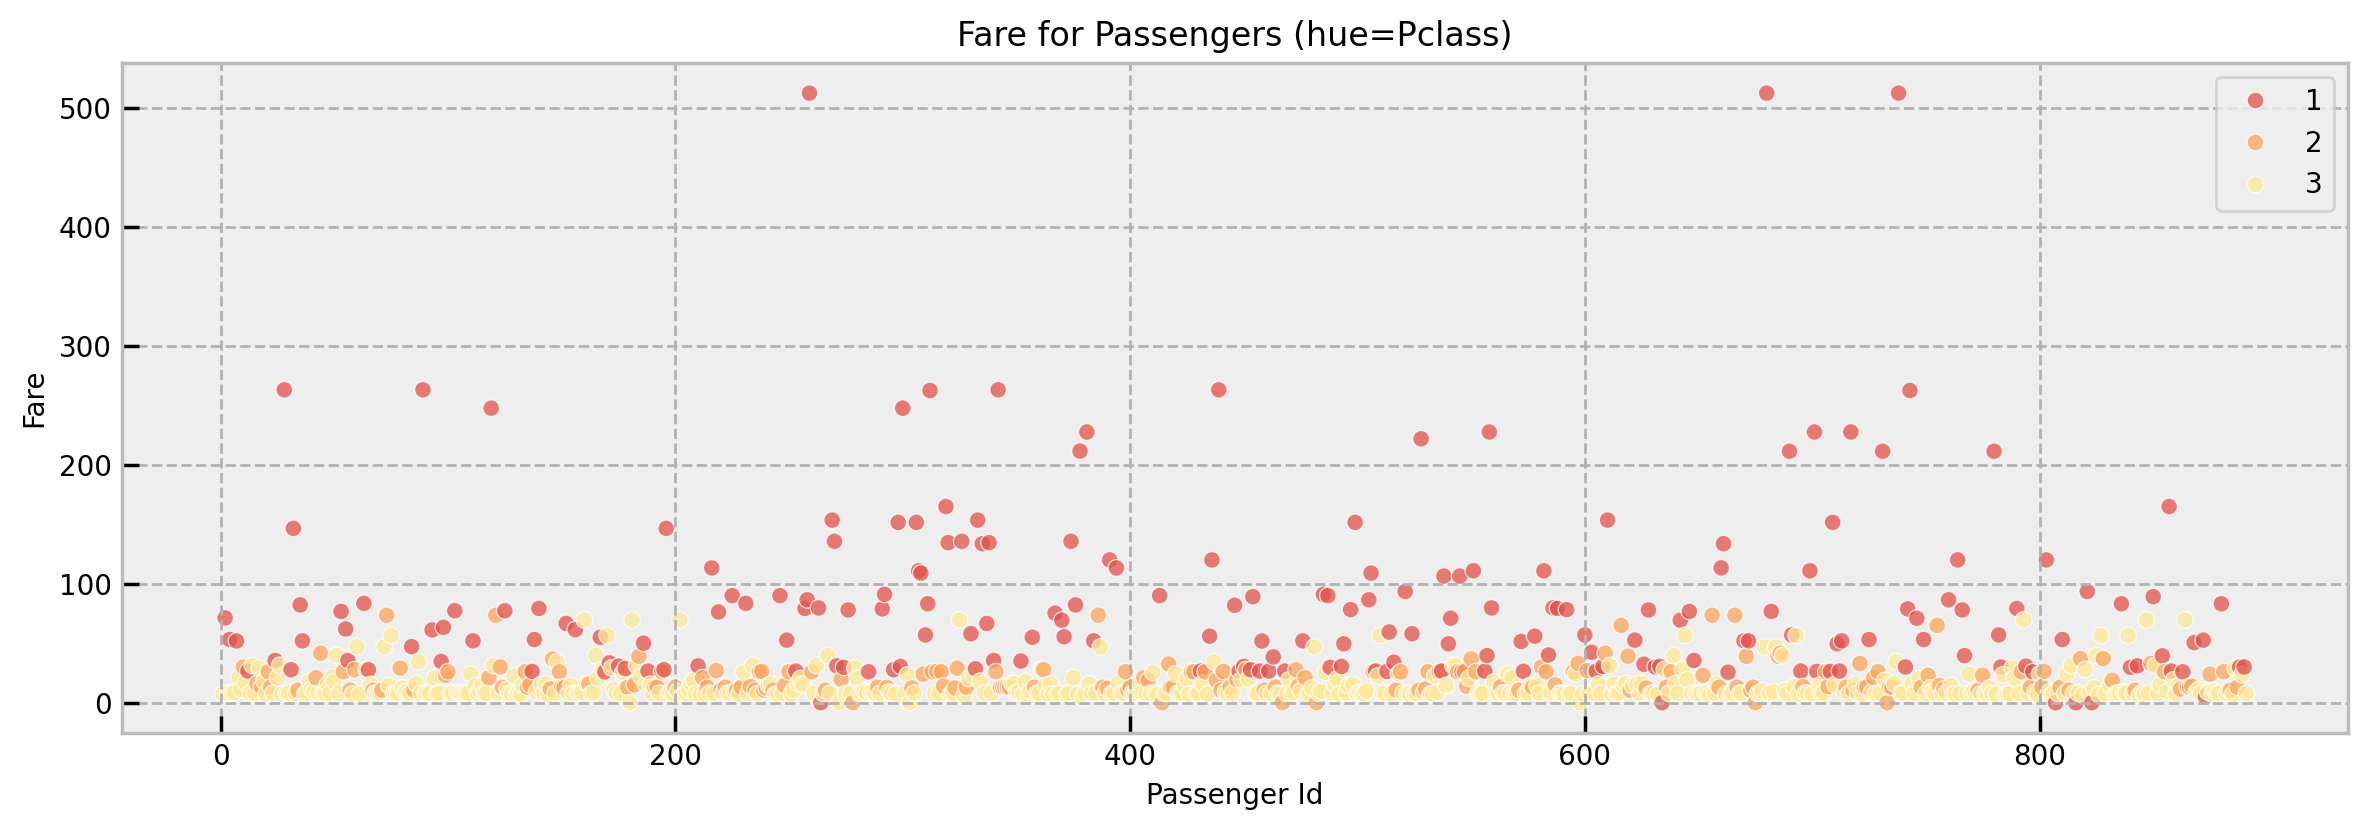

In [688]:
fig = plt.figure(figsize=(12, 4.3))
colors = sns.color_palette('Spectral')
sns.scatterplot(x=train_df.PassengerId, y=train_df.Fare, hue=train_df.Pclass, palette=colors, alpha=0.75)
plt.title('Fare for Passengers (hue=Pclass)')
plt.xlabel('Passenger Id', fontsize=10), plt.ylabel('Fare', fontsize=10)
plt.xticks(fontsize=10), plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [689]:
rows_to_remove = 3
indexes_to_remove = train_df.sort_values('Fare', ascending=False).iloc[:rows_to_remove].index
train_df = train_df.drop(indexes_to_remove, axis=0).reset_index(drop=True).copy()
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,HasCabin,Deck,Embarked_C,Embarked_Q,Embarked_S,Relatives,TicketPrefix
0,1,0,3,1,22.0,7.2500,0,0.299526,0,0,1,1,0.091213
1,2,1,1,0,38.0,71.2833,1,0.589633,1,0,0,1,0.645773
2,3,1,3,0,26.0,7.9250,0,0.299526,0,0,1,0,0.441042
3,4,1,1,0,35.0,53.1000,1,0.589633,0,0,1,1,0.382398
4,5,0,3,1,35.0,8.0500,0,0.299526,0,0,1,0,0.382398


In [690]:
train_df.drop('PassengerId', axis=1, inplace=True)
train_df.describe()

,Survived,Pclass,Sex,Age,Fare,HasCabin,Deck,Embarked_C,Embarked_Q,Embarked_S,Relatives,TicketPrefix
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,0.380361,2.316027,0.648984,29.294774,30.470611,0.225734,0.380198,0.186230,0.086907,0.726862,0.908578,0.380648
std,0.485750,0.832607,0.477557,13.002157,41.155721,0.418301,0.156374,0.389512,0.281858,0.445823,1.616859,0.131252
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.299526,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,7.895800,0.000000,0.299526,0.000000,0.000000,0.000000,0.000000,0.382398
50%,0.000000,3.000000,1.000000,28.000000,14.454200,0.000000,0.299526,0.000000,0.000000,1.000000,0.000000,0.382398
75%,1.000000,3.000000,1.000000,35.000000,30.646850,0.000000,0.299526,0.000000,0.000000,1.000000,1.000000,0.382398
max,1.000000,3.000000,1.000000,80.000000,263.000000,1.000000,0.748940,1.000000,1.000000,1.000000,10.000000,1.000000


# Training a Predictive Model

## Data Preperation

In [692]:
train_predictors = train_df.drop('Survived', axis=1).to_numpy().copy()
train_target = train_df.Survived.to_numpy().copy()

test_predictors = test_df.drop('PassengerId', axis=1).to_numpy().copy()

### Feature-Scaler Sampling

In [693]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler

scalers_dict = {
    'StandardScaler': StandardScaler, 
    'Normalizer': Normalizer, 
    'MinMaxScaler': MinMaxScaler, 
    'RobustScaler': RobustScaler
}
for name, feature_scaler in scalers_dict.items():

    scelar_selector_pipe = Pipeline([
        ('scaler', feature_scaler()),
        ('model', LogisticRegression())
    ]) \
    .fit(train_predictors, train_target)

    preds = scelar_selector_pipe.predict(train_predictors)
    score = scelar_selector_pipe.score(train_predictors, train_target)
    mse = mean_squared_error(train_target, preds)
    rmse = root_mean_squared_error(train_target, preds)

    print(f"""| {name:<14} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R²: {score:.4f} |""")


| StandardScaler | MSE: 0.1953 | RMSE: 0.4419 | R²: 0.8047 |
| Normalizer     | MSE: 0.3104 | RMSE: 0.5571 | R²: 0.6896 |
| MinMaxScaler   | MSE: 0.1885 | RMSE: 0.4342 | R²: 0.8115 |
| RobustScaler   | MSE: 0.1919 | RMSE: 0.4380 | R²: 0.8081 |


### Choosing Train/Validation Split

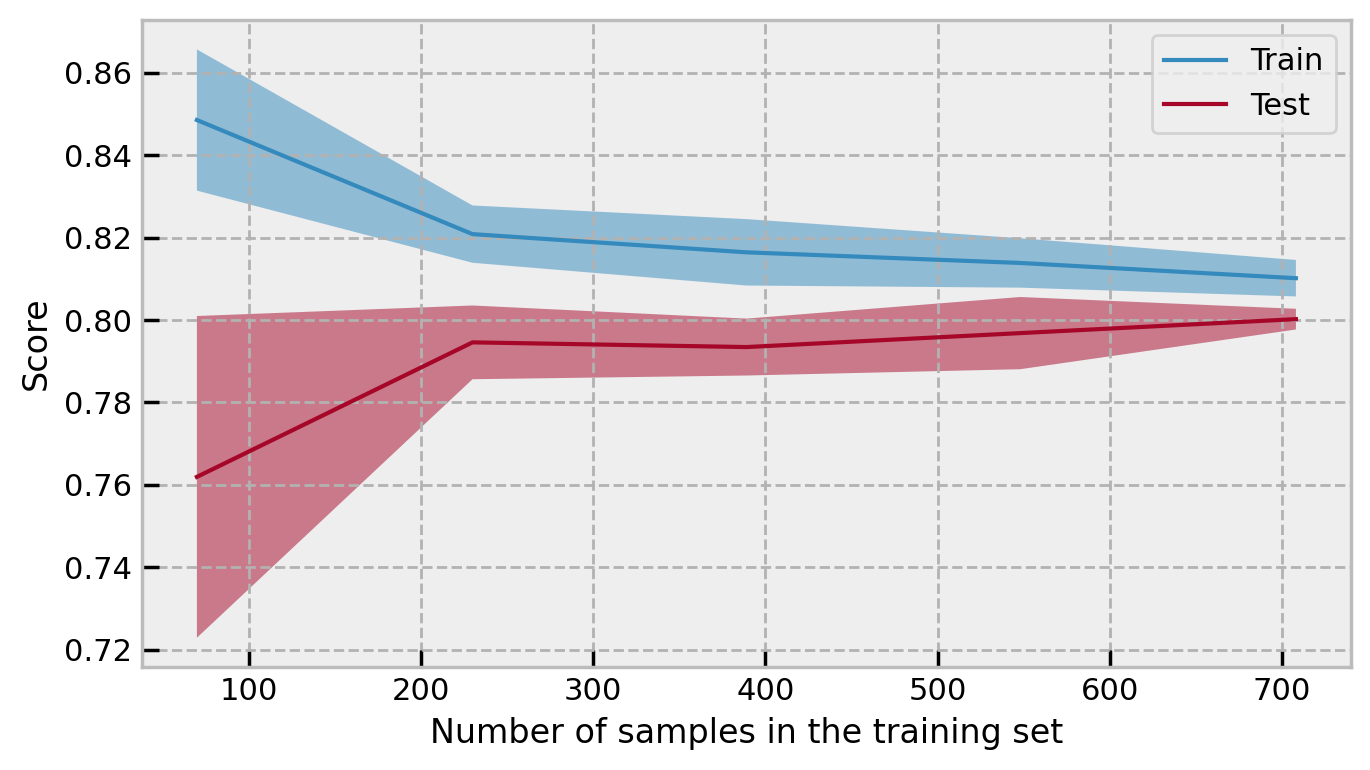

In [694]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve

train_size_abs, train_scores, test_scores = learning_curve(scelar_selector_pipe, train_predictors, train_target)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
display = LearningCurveDisplay(
    train_sizes=train_size_abs, 
    train_scores=train_scores, 
    test_scores=test_scores, 
    score_name="Score"
    )
display.plot(ax=ax)
plt.tight_layout()
plt.show()

In [695]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_predictors, train_target, test_size=.2, shuffle=True)
print(f"""
| X_train.shape: {X_train.shape} | X_val.shape: {X_val.shape} | X_test.shape: {test_predictors.shape}
| -----------------------------------------------------------------------------
| y_train.shape: {y_train.shape} | y_val.shape: {y_val.shape}
""")


| X_train.shape: (708, 11) | X_val.shape: (178, 11) | X_test.shape: (418, 11)
| -----------------------------------------------------------------------------
| y_train.shape: (708,) | y_val.shape: (178,)



## Train and Evaluate

In [696]:
model_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression())
])\
    .fit(X_train, y_train)

preds = model_pipe.predict(X_val)
score = model_pipe.score(X_val, y_val)
mse = mean_squared_error(y_val, preds)
rmse = root_mean_squared_error(y_val, preds)

print(f"""| {name:<14} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R²: {score:.4f} |""")

| RobustScaler   | MSE: 0.1461 | RMSE: 0.3822 | R²: 0.8539 |


# Saving Predictions

In [697]:
y_test = model_pipe.predict(test_predictors)
test_df['Survived'] = y_test
submission = test_df[['PassengerId', 'Survived']]

In [698]:
submission.to_csv('predictions.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
